### Take ERA5 data and compute the weighted sums or averages over the water basins

In [13]:
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
from pathlib import Path
from shapely.geometry import box
from shapely.prepared import prep
from glob import glob
import warnings
warnings.filterwarnings('ignore')

def create_grid_cells(lons, lats):
    """
    Create polygon geometries for each grid cell.
    Returns a dictionary mapping (i, j) indices to cell geometry.
    """
    grid_cells = {}
    
    # Calculate cell boundaries
    lat_res = abs(lats[1] - lats[0]) if len(lats) > 1 else 0.25
    lon_res = abs(lons[1] - lons[0]) if len(lons) > 1 else 0.25
    
    for i, lat in enumerate(lats):
        for j, lon in enumerate(lons):
            # Create cell boundaries (center ± half resolution)
            min_lon = lon - lon_res / 2
            max_lon = lon + lon_res / 2
            min_lat = lat - lat_res / 2
            max_lat = lat + lat_res / 2
            
            # Create box geometry
            cell_geom = box(min_lon, min_lat, max_lon, max_lat)
            grid_cells[(i, j)] = cell_geom
    
    return grid_cells

def calculate_basin_weights(basins, grid_cells, station_nums):
    """
    Calculate fractional overlap weights for specified basins with grid cells.
    Returns dict mapping basin_id -> {(i,j): overlap_fraction}
    """
    basin_weights = {}
    
    # Filter basins to only those in station_nums
    basins_filtered = basins[basins['StationNum'].isin(station_nums)]
    
    print(f"Calculating overlaps for {len(basins_filtered)} basins...")
    
    for idx, basin in basins_filtered.iterrows():
        basin_id = basin['StationNum']
        basin_geom = basin.geometry
        
        # Prepare geometry for faster intersection tests
        prepared_basin = prep(basin_geom)
        
        weights = {}
        
        # Check each grid cell for overlap
        for (i, j), cell_geom in grid_cells.items():
            # Quick bbox test first
            if not prepared_basin.intersects(cell_geom):
                continue
            
            # Calculate actual intersection
            try:
                intersection = basin_geom.intersection(cell_geom)
                if not intersection.is_empty:
                    # Calculate intersection area
                    overlap_area = intersection.area
                    cell_total_area = cell_geom.area
                    
                    # Weight is the fraction of the cell that overlaps
                    weights[(i, j)] = overlap_area / cell_total_area
            except Exception as e:
                print(f"  Warning: Error calculating overlap for basin {basin_id}, cell ({i},{j}): {e}")
                continue
        
        if len(weights) > 0:
            basin_weights[basin_id] = weights
            if idx % 10 == 0:  # Progress update every 10 basins
                print(f"  Processed {idx + 1}/{len(basins_filtered)} basins...")
        else:
            print(f"  Warning: No grid cell overlap found for basin {basin_id}")
    
    return basin_weights

def process_precipitation_file(nc_path, basin_weights, lats, lons):
    """
    Process a single precipitation NetCDF file.
    Returns DataFrame with columns: date, StationNum, value
    """
    print(f"  Processing {nc_path.name}...")
    
    # Open dataset
    ds = xr.open_dataset(nc_path)
    
    # Identify precipitation variable
    precip_var = None
    for var in ['tp', 'precip', 'precipitation', 'total_precipitation']:
        if var in ds.variables:
            precip_var = var
            break
    
    if precip_var is None:
        raise ValueError(f"Could not find precipitation variable in {nc_path}")
    
    # Get time dimension
    if 'valid_time' in ds.coords:
        times = pd.to_datetime(ds['valid_time'].values)
        time_dim = 'valid_time'
    elif 'time' in ds.coords:
        times = pd.to_datetime(ds['time'].values)
        time_dim = 'time'
    else:
        raise ValueError(f"No time dimension found in {nc_path}")
    
    # Convert from UTC to Alberta time (UTC-7) if precipitation is also in UTC
    # Comment out the next line if your precipitation data is already in Alberta time
    # times = times - pd.Timedelta(hours=7)
    
    # Store results for this file
    results = []
    
    # Process each time step
    for t_idx, time in enumerate(times):
        # Get data for this time step
        data = ds[precip_var].isel(**{time_dim: t_idx}).values
        
        # ERA5 precipitation is in meters, convert to mm
        data_mm = data * 1000
        
        # Calculate for each basin
        for basin_id, weights in basin_weights.items():
            total_value = 0
            total_weight = 0
            
            for (i, j), weight in weights.items():
                cell_value = data_mm[i, j]
                if not np.isnan(cell_value):
                    total_value += cell_value * weight
                    total_weight += weight
            
            # Total precipitation is area-weighted sum
            if total_weight > 0:
                basin_value = total_value / total_weight
            else:
                basin_value = 0
            
            results.append({
                'date': time,
                'StationNum': basin_id,
                'value': basin_value
            })
    
    ds.close()
    
    return pd.DataFrame(results)

def process_temperature_grib(grib_path, basin_weights, lats, lons):
    """
    Process a single temperature GRIB file using cfgrib/eccodes backend.
    Returns three DataFrames: (daily_min, daily_max, daily_mean)
    """
    print(f"  Processing {grib_path.name}...")
    
    # Open GRIB file using cfgrib with eccodes engine
    try:
        ds = xr.open_dataset(grib_path, engine='cfgrib')
    except Exception as e:
        print(f"  Error opening GRIB file with cfgrib: {e}")
        print("  Make sure cfgrib is installed: pip install cfgrib")
        raise
    
    # Identify temperature variable
    temp_var = None
    for var in ['t2m', 't', 'temp', 'temperature', '2t']:
        if var in ds.variables:
            temp_var = var
            break
    
    if temp_var is None:
        print(f"  Available variables in GRIB: {list(ds.variables)}")
        ds.close()
        raise ValueError(f"Could not find temperature variable in {grib_path}")
    
    # GRIB files have 'time' as dimension
    time_dim = 'time'
    
    if time_dim not in ds.dims:
        print(f"  Available dimensions in GRIB: {list(ds.dims)}")
        ds.close()
        raise ValueError(f"No time dimension found in {grib_path}")
    
    # Get times - prefer valid_time coordinate if available
    if 'valid_time' in ds.coords:
        times = pd.to_datetime(ds['valid_time'].values)
    elif 'time' in ds.coords:
        times = pd.to_datetime(ds['time'].values)
    else:
        ds.close()
        raise ValueError(f"No time coordinate found in {grib_path}")
    
    # Convert from UTC to Alberta time (UTC-7)
    times = times - pd.Timedelta(hours=7)
    
    print(f"    Loading all temperature data into memory...")
    # Load all temperature data at once and convert to Celsius
    temp_data_all = ds[temp_var].values - 273.15  # Shape: (time, lat, lon)
    ds.close()
    
    print(f"    Computing basin averages for all timesteps...")
    # Pre-compute basin temperatures for all time steps (vectorized)
    basin_ids = list(basin_weights.keys())
    n_times = len(times)
    n_basins = len(basin_ids)
    
    # Create array to store basin temperatures: (n_times, n_basins)
    basin_temps = np.zeros((n_times, n_basins))
    
    # Process each basin
    for basin_idx, basin_id in enumerate(basin_ids):
        if basin_idx % 10 == 0:
            print(f"      Processing basin {basin_idx + 1}/{n_basins}...")
        
        weights = basin_weights[basin_id]
        
        # Extract weighted temperatures for all time steps at once
        weighted_sum = 0
        total_weight = 0
        
        for (i, j), weight in weights.items():
            # Get temperature time series for this grid cell
            cell_temps = temp_data_all[:, i, j]  # Shape: (n_times,)
            weighted_sum += cell_temps * weight
            total_weight += weight
        
        # Calculate basin average for all times
        if total_weight > 0:
            basin_temps[:, basin_idx] = weighted_sum / total_weight
    
    print(f"    Computing daily statistics...")
    # Create DataFrame with times and basin temperatures
    temp_df = pd.DataFrame(basin_temps, columns=basin_ids)
    temp_df['datetime'] = times
    temp_df['date'] = temp_df['datetime'].dt.date
    
    # Group by date and compute statistics, aggregating duplicates
    min_results = []
    max_results = []
    mean_results = []
    
    for date, group in temp_df.groupby('date'):
        for basin_id in basin_ids:
            temps = group[basin_id].values
            # Remove any NaN values
            temps = temps[~np.isnan(temps)]
            
            if len(temps) > 0:
                min_results.append({
                    'date': date,
                    'StationNum': basin_id,
                    'value': np.min(temps)
                })
                max_results.append({
                    'date': date,
                    'StationNum': basin_id,
                    'value': np.max(temps)
                })
                mean_results.append({
                    'date': date,
                    'StationNum': basin_id,
                    'value': np.mean(temps)
                })
    
    print(f"    Completed processing {grib_path.name}")
    
    return (pd.DataFrame(min_results), 
            pd.DataFrame(max_results), 
            pd.DataFrame(mean_results))

def compute_basin_climate_data(
    precip_dir,
    temp_dir,
    shapefile_path,
    station_metadata_path,
    output_dir='basin_averaged_climate_data'
):
    """
    Compute daily precipitation and temperature statistics for specified water basins.
    
    Parameters:
    -----------
    precip_dir : str
        Directory containing ERA5 precipitation NetCDF files
    temp_dir : str
        Directory containing ERA5 temperature GRIB files
    shapefile_path : str
        Path to basin shapefile
    station_metadata_path : str
        Path to CSV with station metadata (must include StationNum column)
    output_dir : str
        Directory to save output CSV files
    """
    
    # Create output directory
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    # Load station metadata to get list of stations to process
    print("Loading station metadata...")
    station_metadata = pd.read_csv(station_metadata_path)
    station_nums = station_metadata['StationNum'].tolist()
    print(f"Found {len(station_nums)} stations to process")
    
    # Read the basin shapefile
    print("\nLoading basin shapefile...")
    basins = gpd.read_file(shapefile_path)
    
    # Ensure the basins have a CRS
    if basins.crs is None:
        print("Warning: Shapefile has no CRS, assuming EPSG:4326 (WGS84)")
        basins.set_crs("EPSG:4326", inplace=True)
    
    # Reproject basins to WGS84 if needed
    if basins.crs.to_string() != "EPSG:4326":
        print(f"Reprojecting basins from {basins.crs} to EPSG:4326")
        basins = basins.to_crs("EPSG:4326")
    
    print(f"Total basins in shapefile: {len(basins)}")
    print(f"Basins matching station list: {len(basins[basins['StationNum'].isin(station_nums)])}")
    
    # Get precipitation files
    print("\nReading grid structure from sample NetCDF file...")
    precip_files = sorted(glob(str(Path(precip_dir) / "era5_precip_*.nc")))
    
    if len(precip_files) == 0:
        raise ValueError(f"No precipitation NetCDF files found in {precip_dir}")
    
    print(f"Found {len(precip_files)} precipitation files to process")
    
    # Get temperature files
    temp_files = sorted(glob(str(Path(temp_dir) / "era5_temp_*.grib")))
    
    if len(temp_files) == 0:
        raise ValueError(f"No temperature GRIB files found in {temp_dir}")
    
    print(f"Found {len(temp_files)} temperature files to process")
    
    # Load first precipitation file to get coordinate structure
    sample_ds = xr.open_dataset(precip_files[0])
    
    # Extract coordinates
    if 'latitude' in sample_ds.coords:
        lat_name, lon_name = 'latitude', 'longitude'
    elif 'lat' in sample_ds.coords:
        lat_name, lon_name = 'lat', 'lon'
    else:
        raise ValueError("Could not identify latitude/longitude coordinates")
    
    lats = sample_ds[lat_name].values
    lons = sample_ds[lon_name].values
    sample_ds.close()
    
    print(f"Grid dimensions: {len(lats)} lat × {len(lons)} lon")
    
    # Create grid cell geometries (only need to do this once)
    print("\nCreating grid cell geometries...")
    grid_cells = create_grid_cells(lons, lats)
    
    # Calculate basin-grid overlaps (only need to do this once)
    print("\nCalculating basin-grid overlaps...")
    basin_weights = calculate_basin_weights(basins, grid_cells, station_nums)
    
    print(f"\nSuccessfully calculated overlaps for {len(basin_weights)} basins")
    
    # Process precipitation files
    print("\n" + "="*60)
    print("PROCESSING PRECIPITATION DATA")
    print("="*60)
    precip_results = []
    
    for nc_file in precip_files:
        nc_path = Path(nc_file)
        df = process_precipitation_file(nc_path, basin_weights, lats, lons)
        precip_results.append(df)
    
    # Combine precipitation results
    print("\nCombining precipitation results...")
    combined_precip = pd.concat(precip_results, ignore_index=True)
    combined_precip['date'] = pd.to_datetime(combined_precip['date']).dt.date
    combined_precip = combined_precip.sort_values(['date', 'StationNum']).reset_index(drop=True)
    
    # Pivot to wide format
    print("Pivoting precipitation to wide format...")
    precip_wide = combined_precip.pivot(index='date', columns='StationNum', values='value')
    precip_wide = precip_wide.sort_index().reset_index()
    
    # Save precipitation
    precip_file = output_path / "basin_total_precipitation.csv"
    precip_wide.to_csv(precip_file, index=False)
    print(f"Saved precipitation to: {precip_file}")
    print(f"Shape: {precip_wide.shape[0]} days × {precip_wide.shape[1]-1} stations")
    
    # Process temperature files
    print("\n" + "="*60)
    print("PROCESSING TEMPERATURE DATA (GRIB)")
    print("="*60)
    temp_min_results = []
    temp_max_results = []
    temp_mean_results = []
    
    for grib_file in temp_files:
        grib_path = Path(grib_file)
        min_df, max_df, mean_df = process_temperature_grib(grib_path, basin_weights, lats, lons)
        
        temp_min_results.append(min_df)
        temp_max_results.append(max_df)
        temp_mean_results.append(mean_df)
    
    # Combine temperature results
    print("\nCombining temperature results...")
    
    # Min temperature
    combined_min = pd.concat(temp_min_results, ignore_index=True)
    # Handle any duplicate date+station combinations by taking the min
    combined_min = combined_min.groupby(['date', 'StationNum'], as_index=False)['value'].min()
    combined_min = combined_min.sort_values(['date', 'StationNum']).reset_index(drop=True)
    temp_min_wide = combined_min.pivot(index='date', columns='StationNum', values='value')
    temp_min_wide = temp_min_wide.sort_index().reset_index()
    
    # Max temperature
    combined_max = pd.concat(temp_max_results, ignore_index=True)
    # Handle any duplicate date+station combinations by taking the max
    combined_max = combined_max.groupby(['date', 'StationNum'], as_index=False)['value'].max()
    combined_max = combined_max.sort_values(['date', 'StationNum']).reset_index(drop=True)
    temp_max_wide = combined_max.pivot(index='date', columns='StationNum', values='value')
    temp_max_wide = temp_max_wide.sort_index().reset_index()
    
    # Mean temperature
    combined_mean = pd.concat(temp_mean_results, ignore_index=True)
    # Handle any duplicate date+station combinations by taking the mean
    combined_mean = combined_mean.groupby(['date', 'StationNum'], as_index=False)['value'].mean()
    combined_mean = combined_mean.sort_values(['date', 'StationNum']).reset_index(drop=True)
    temp_mean_wide = combined_mean.pivot(index='date', columns='StationNum', values='value')
    temp_mean_wide = temp_mean_wide.sort_index().reset_index()
    
    # Save temperature files
    temp_min_file = output_path / "basin_min_temperature.csv"
    temp_max_file = output_path / "basin_max_temperature.csv"
    temp_mean_file = output_path / "basin_mean_temperature.csv"
    
    temp_min_wide.to_csv(temp_min_file, index=False)
    temp_max_wide.to_csv(temp_max_file, index=False)
    temp_mean_wide.to_csv(temp_mean_file, index=False)
    
    print(f"\nSaved min temperature to: {temp_min_file}")
    print(f"Saved max temperature to: {temp_max_file}")
    print(f"Saved mean temperature to: {temp_mean_file}")
    print(f"Shape: {temp_min_wide.shape[0]} days × {temp_min_wide.shape[1]-1} stations")
    
    # Print summary statistics
    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    print(f"\nPRECIPITATION:")
    print(f"  Date range: {precip_wide['date'].min()} to {precip_wide['date'].max()}")
    print(f"  Number of stations: {precip_wide.shape[1] - 1}")
    print(f"  Total days: {len(precip_wide)}")
    precip_values = precip_wide.iloc[:, 1:].values.flatten()
    precip_values = precip_values[~np.isnan(precip_values)]
    print(f"  Statistics (mm/day):")
    print(f"    Mean: {np.mean(precip_values):.2f}")
    print(f"    Std: {np.std(precip_values):.2f}")
    print(f"    Min: {np.min(precip_values):.2f}")
    print(f"    Max: {np.max(precip_values):.2f}")
    
    print(f"\nTEMPERATURE:")
    print(f"  Date range: {temp_mean_wide['date'].min()} to {temp_mean_wide['date'].max()}")
    print(f"  Number of stations: {temp_mean_wide.shape[1] - 1}")
    print(f"  Total days: {len(temp_mean_wide)}")
    
    temp_min_values = temp_min_wide.iloc[:, 1:].values.flatten()
    temp_min_values = temp_min_values[~np.isnan(temp_min_values)]
    temp_max_values = temp_max_wide.iloc[:, 1:].values.flatten()
    temp_max_values = temp_max_values[~np.isnan(temp_max_values)]
    temp_mean_values = temp_mean_wide.iloc[:, 1:].values.flatten()
    temp_mean_values = temp_mean_values[~np.isnan(temp_mean_values)]
    
    print(f"  Min Temperature Statistics (°C):")
    print(f"    Mean: {np.mean(temp_min_values):.2f}")
    print(f"    Std: {np.std(temp_min_values):.2f}")
    print(f"    Range: {np.min(temp_min_values):.2f} to {np.max(temp_min_values):.2f}")
    
    print(f"  Max Temperature Statistics (°C):")
    print(f"    Mean: {np.mean(temp_max_values):.2f}")
    print(f"    Std: {np.std(temp_max_values):.2f}")
    print(f"    Range: {np.min(temp_max_values):.2f} to {np.max(temp_max_values):.2f}")
    
    print(f"  Mean Temperature Statistics (°C):")
    print(f"    Mean: {np.mean(temp_mean_values):.2f}")
    print(f"    Std: {np.std(temp_mean_values):.2f}")
    print(f"    Range: {np.min(temp_mean_values):.2f} to {np.max(temp_mean_values):.2f}")
    
    return precip_wide, temp_min_wide, temp_max_wide, temp_mean_wide

if __name__ == "__main__":
    # Run the analysis
    results = compute_basin_climate_data(
        precip_dir="ERA5_data/ERA5_precip",
        temp_dir="ERA5_data/ERA5_temp",
        shapefile_path="derived_shapefiles/natural_watersheds.shp",
        station_metadata_path="station_cluster_metadata.csv",
        output_dir="basin_averaged_climate_data"
    )
    
    print("\n" + "="*60)
    print("Processing complete!")
    print("="*60)

Loading station metadata...
Found 111 stations to process

Loading basin shapefile...
Reprojecting basins from PROJCS["Canada_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","102001"]] to EPSG:4326
Total basins in shapefile: 555
Basins matching station list: 111

Reading grid structure from sample NetCDF file...
Found 516 precipitation files to process
Found 43 temperature files to process
Grid dimensi

### View data

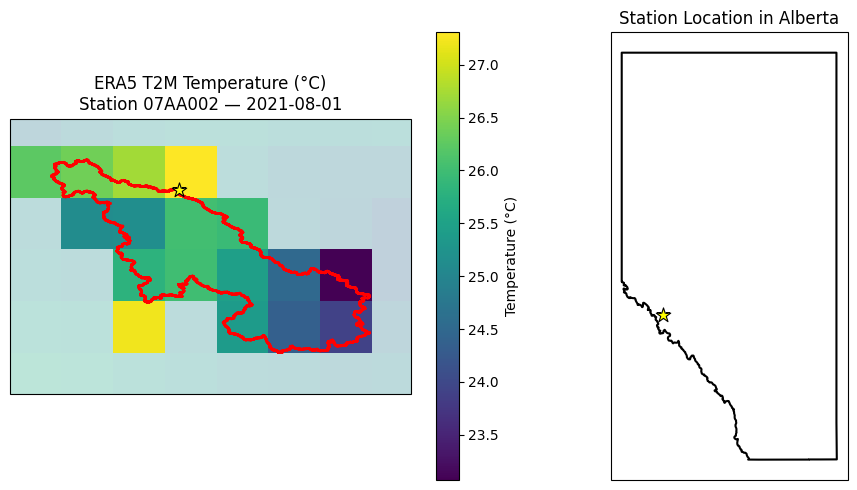

In [49]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from shapely.geometry import box, Polygon
from shapely.prepared import prep
from pathlib import Path
import pandas as pd

def create_grid_cells(lons, lats):
    grid_cells = {}
    lat_res = abs(lats[1] - lats[0])
    lon_res = abs(lons[1] - lons[0])
    for i, lat in enumerate(lats):
        for j, lon in enumerate(lons):
            min_lon = lon - lon_res/2
            max_lon = lon + lon_res/2
            min_lat = lat - lat_res/2
            max_lat = lat + lat_res/2
            grid_cells[(i, j)] = box(min_lon, min_lat, max_lon, max_lat)
    return grid_cells

# ----------------------------------------------------------
# USER PATHS
# ----------------------------------------------------------
precip_dir = Path("ERA5_data/ERA5_temp")
basin_shp = Path("derived_shapefiles/natural_watersheds.shp")
meta_csv = Path("station_cluster_metadata.csv")

ab_lat_csv = Path("AB_boundary/ABlat.csv")
ab_lon_csv = Path("AB_boundary/ABlon.csv")

station_id = "05DA009"
station_id = "07AA002"
target_date = "2021-08-01"

# ----------------------------------------------------------
# Load station metadata
# ----------------------------------------------------------
meta = pd.read_csv(meta_csv)
station_row = meta[meta["StationNum"] == station_id].iloc[0]
station_lat = station_row["lat"]
station_lon = station_row["lon"]

# ----------------------------------------------------------
# Load basin
# ----------------------------------------------------------
basins = gpd.read_file(basin_shp).to_crs("EPSG:4326")
basin = basins[basins["StationNum"] == station_id].iloc[0]
basin_geom = basin.geometry
prepared_basin = prep(basin_geom)

# ----------------------------------------------------------
# Load Alberta boundary
# ----------------------------------------------------------
AB_lats = pd.read_csv(ab_lat_csv).values.flatten()
AB_lons = pd.read_csv(ab_lon_csv).values.flatten()
AB_polygon = Polygon(zip(AB_lons, AB_lats))
AB_gdf = gpd.GeoDataFrame({"geometry": [AB_polygon]}, crs="EPSG:4326")

# ----------------------------------------------------------
# Load temperature file containing target date
# ----------------------------------------------------------
files = sorted(precip_dir.glob("*.grib"))
target_file = next((f for f in files if "2021" in f.name), None)
if target_file is None:
    raise ValueError("No 2021 file found.")

ds = xr.open_dataset(target_file, engine="cfgrib")
temp_var = "t2m" if "t2m" in ds.variables else list(ds.variables)[0]

times = np.array(ds["time"].values, dtype="datetime64[ns]")
t_idx = np.where(times == np.datetime64(target_date))[0]
if len(t_idx) == 0:
    raise ValueError(f"Date {target_date} not found.")
t_idx = t_idx[0]

data = ds[temp_var].isel(time=t_idx).values - 273.15
lats = ds["latitude"].values
lons = ds["longitude"].values
ds.close()

# ----------------------------------------------------------
# Clip to basin
# ----------------------------------------------------------
grid_cells = create_grid_cells(lons, lats)
masked_data = np.full_like(data, np.nan)

for (i, j), geom in grid_cells.items():
    if prepared_basin.intersects(geom):
        masked_data[i, j] = data[i, j]

# ----------------------------------------------------------
# FIGURE — MAIN PLOT + Alberta Inset
# ----------------------------------------------------------
fig = plt.figure(figsize=(10, 5))

# Main temperature field plot
ax_main = plt.subplot2grid((1, 2), (0, 0), projection=ccrs.PlateCarree())

pc = ax_main.pcolormesh(
    lons, lats, data,
    shading="auto",
    alpha=0.30,
    transform=ccrs.PlateCarree()
)

bc = ax_main.pcolormesh(
    lons, lats, masked_data,
    shading="auto",
    transform=ccrs.PlateCarree()
)

gpd.GeoSeries([basin_geom]).plot(
    ax=ax_main, facecolor="none", edgecolor="red", linewidth=2
)

# Add station star
ax_main.scatter(station_lon, station_lat, color="yellow", s=120,
                marker="*", edgecolors="black", linewidth=0.8,
                transform=ccrs.PlateCarree())

# Zoom to basin
minx, miny, maxx, maxy = basin_geom.bounds
pad = 0.2
ax_main.set_extent([minx - pad, maxx + pad, miny - pad, maxy + pad],
                   crs=ccrs.PlateCarree())

ax_main.set_title(f"ERA5 T2M Temperature (°C)\nStation {station_id} — {target_date}")
plt.colorbar(bc, ax=ax_main, label="Temperature (°C)")

# ----------------------------------------------------------
# Alberta inset — no bounding box
# ----------------------------------------------------------
ax_ab = plt.subplot2grid((1, 2), (0, 1), projection=ccrs.PlateCarree())

AB_gdf.boundary.plot(ax=ax_ab, color="black")
ax_ab.scatter(station_lon, station_lat, color="yellow", s=120,
                marker="*", edgecolors="black", linewidth=0.8,
                transform=ccrs.PlateCarree())
ax_ab.set_title("Station Location in Alberta")

# DO NOT set extent → avoids the bounding box

plt.tight_layout()
plt.show()
